In [1]:
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression
from glob import glob
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA, FactorAnalysis

/home/hv270/platelets/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"

In [3]:
adjusted_cell_data = False
if adjusted_cell_data:
    PLT = pd.read_hdf("%s/processed/PLT.hdf" % data_dir,key="PLT")
else:
    PLT = pd.read_hdf("%s/processed/PLT_unadjusted.hdf" % data_dir,key="PLT")

In [4]:
X = PLT

In [5]:
sys_cohort = ~PLT.ID.str.contains("INT_116")

In [6]:
plt_sys = PLT.loc[sys_cohort].sample(3000)
plt_int = PLT.loc[~sys_cohort].sample(3000)

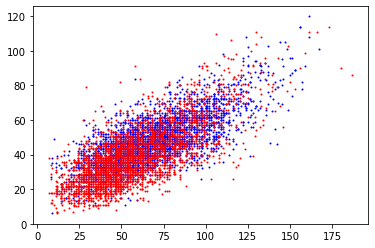

In [7]:
plt.scatter(plt_sys["FSC"],plt_sys["SSC"],c="blue",s=1)
plt.scatter(plt_int["FSC"],plt_int["SSC"],c="red",s=1)

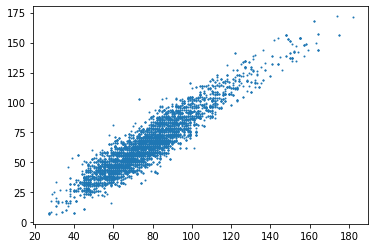

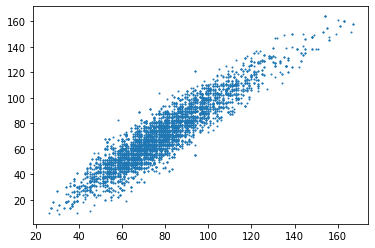

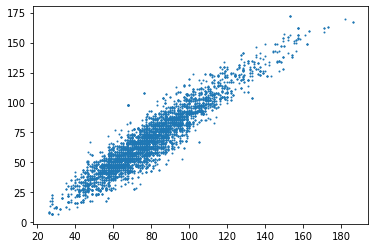

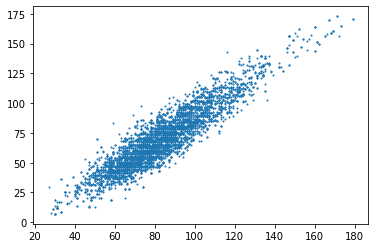

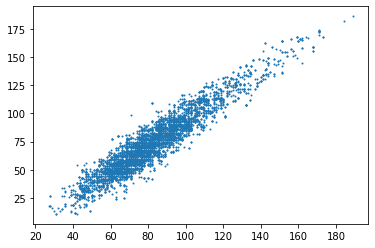

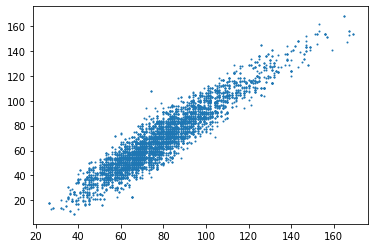

In [8]:
i = 0
for ID, sys in PLT.loc[sys_cohort].groupby("ID"):
    plt.figure()
    plt.scatter(sys.SFL, sys.FSC, s= 1)
    i += 1
    if i > 5:
        break

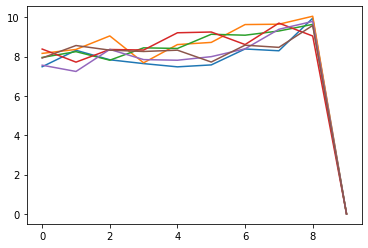

In [9]:
i = 0
for ID, sys in PLT.loc[sys_cohort].groupby("ID"):
    pca = PCA(n_components=2).fit(sys[FACS_COLS])
    sys_t = pca.transform(sys[FACS_COLS])
    #plt.scatter(sys_t[:,0],sys_t[:,1],s=1)
    bins = np.quantile(sys_t[:,0],np.linspace(0,1,10))
    digits = np.digitize(sys_t[:,0],bins)
    means = np.array([np.std(sys_t[digits==d,1]) for d in np.unique(digits)])
    plt.plot(means)
    #plt.hist(sys_t[:,0],histtype="step",bins=30)
    i += 1
    if i > 5:
        break

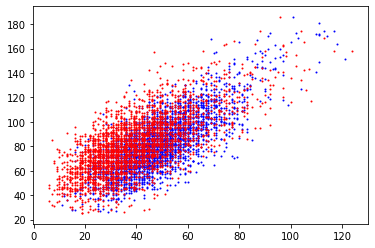

In [10]:
plt.scatter(plt_sys["SSC"],plt_sys["SFL"],c="blue",s=1)
plt.scatter(plt_int["SSC"],plt_int["SFL"],c="red",s=1)

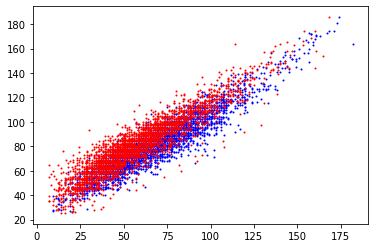

In [11]:
plt.scatter(plt_sys["FSC"],plt_sys["SFL"],c="blue",s=1)
plt.scatter(plt_int["FSC"],plt_int["SFL"],c="red",s=1)

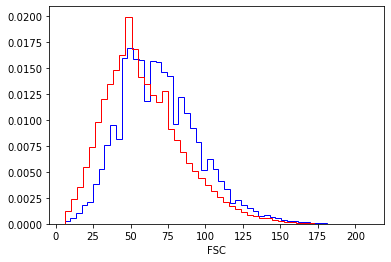

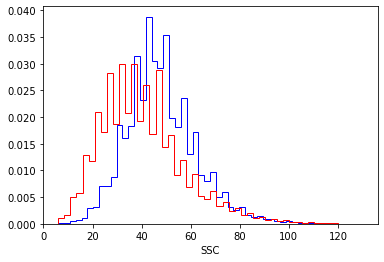

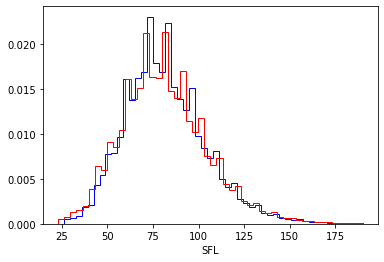

In [12]:
for c in FACS_COLS:
    plt.figure()
    plt.hist(PLT.loc[sys_cohort,c],histtype="step",density=True,bins=50,color="blue")
    plt.hist(PLT.loc[~sys_cohort,c],histtype="step",density=True,bins=50,color="red")
    plt.xlabel(c)

# Look at discrpancies between PCAs on two cohorts

In [13]:
pca = PCA(n_components=2)
pca_int = PCA(n_components=2)

In [14]:
pca.fit(X.loc[sys_cohort,FACS_COLS])
print(pca.components_)
#print(pca.explained_variance_ratio_)
print(pca.noise_variance_)
pca_int.fit(X.loc[~sys_cohort,FACS_COLS])
print(pca_int.components_)
#print(pca.explained_variance_ratio_)
print(pca_int.noise_variance_)

[[ 0.72067024  0.32234329  0.6137827 ]
 [-0.31824032  0.9403599  -0.12019299]]
38.8339131515188
[[ 0.69240315  0.37453986  0.61668288]
 [-0.25935497  0.92678278 -0.27167755]]
46.241192183399335


# Apply PCA and build features

In [15]:
#pca.fit(X.loc[sys_cohort,FACS_COLS])
#pca_int.fit(X.loc[~sys_cohort,FACS_COLS])
X[["X_0","X_1"]] = pca.transform(X[FACS_COLS])
#X.loc[~sys_cohort,["X_0","X_1"]] = pca_int.transform(X.loc[~sys_cohort,FACS_COLS])

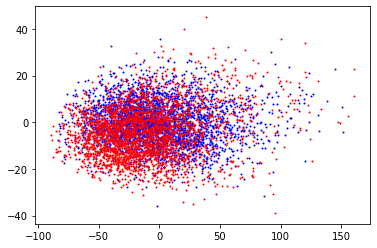

In [16]:
X_sys = X.loc[sys_cohort,["X_0","X_1"]].sample(3000)
X_int = X.loc[~sys_cohort,["X_0","X_1"]].sample(3000)
plt.scatter(X_sys["X_0"],X_sys["X_1"],c="blue",s=1)
plt.scatter(X_int["X_0"],X_int["X_1"],c="red",s=1)

In [17]:
g = X.groupby("ID")[["X_0","X_1"]]
mean = g.mean()
median = g.median()
upper = g.quantile(0.9)
lower = g.quantile(0.1)
#upper_ext = g.quantile(0.975)
#lower_ext = g.quantile(0.025)
std = g.std()
iqr = g.quantile(0.75) - g.quantile(0.25)
#skew = g.skew()

ratio_upper = np.log10((upper["X_1"] - median["X_1"])/ (upper["X_0"] - median["X_1"]))
ratio_lower = np.log10((median["X_1"] - lower["X_1"]) / (median["X_0"] - lower["X_0"]))
ratio_std = np.log10(std["X_1"] / std["X_0"])

In [18]:
features = pd.concat([mean.rename(columns={"X_0":"mean_0","X_1":"mean_1"}),
           median.rename(columns={"X_0":"median_0","X_1":"median_1"}),
           upper.rename(columns={"X_0":"upper_0","X_1":"upper_1"}),
           lower.rename(columns={"X_0":"lower_0","X_1":"lower_1"}),
           #upper_ext.rename(columns={"X_0":"upper_ext_0","X_1":"upper_ext_1"}),
           #lower_ext.rename(columns={"X_0":"lower_ext_0","X_1":"lower_ext_1"}),
           std.rename(columns={"X_0":"std_0","X_1":"std_1"}),
           iqr.rename(columns={"X_0":"iqr_0","X_1":"iqr_1"}),
           #iqr_up_1.rename(columns={"X_1":"iqr_up_1"}),
           #iqr_low_1.rename(columns={"X_1":"iqr_low_1"}),
           #iqr_up_0.rename(columns={"X_0":"iqr_up_0"}),
           #iqr_low_0.rename(columns={"X_0":"iqr_low_0"}),
           #skew.rename(columns={"X_0":"skew_0","X_1":"skew_1"}),
           pd.DataFrame(ratio_upper).rename(columns={0:"ratio_upper"}),
           pd.DataFrame(ratio_lower).rename(columns={0:"ratio_lower"}),
           pd.DataFrame(ratio_std).rename(columns={0:"ratio_std"})],axis=1)
features = features.dropna(how="any",axis=0)

In [19]:
features

mean_0     mean_1   median_0   median_1    upper_0  \
ID                                                                      
C0WX14          -5.497325  -0.430304  -8.801307  -0.248671  35.046187   
C0WX4Z          -0.958927  -0.669033  -4.762812  -1.043813  43.274748   
C0WX6V          -1.497133  -0.053734  -5.362014  -0.283413  45.070401   
C0WX7T           2.848043   1.563287  -0.643392   1.333558  47.936865   
C0WX8R           3.375183  -1.904844  -1.581603  -1.991711  51.023822   
...                   ...        ...        ...        ...        ...   
INT_116_99600  -15.639979  -5.531973 -19.324963  -6.271662  28.172642   
INT_116_99700  -18.648952 -14.212979 -21.205540 -14.269666  26.368502   
INT_116_99800  -16.094731  -5.828379 -19.597185  -6.283386  25.983003   
INT_116_99900   -7.346607  -6.227780 -13.294024  -6.928538  46.842841   
INT_116_999400   0.810400  -4.595601  -4.065584  -5.131421  55.692683   

                  upper_1    lower_0    lower_1      std_0     std_1  \
ID                                                                     
C0WX14           9.741645 -41.751377 -10.755764  32.389198  8.181019   
C0WX4Z          11.005409 -39.075309 -11.979563  32.933163  8.943662   
C0WX6V          10.951034 -42.820684 -11.166386  36.064001  8.768345   
C0WX7T          12.702554 -37.429296  -9.509349  34.645643  8.744881   
C0WX8R           8.305408 -37.515335 -12.753138  36.644559  8.377102   
...                   ...        ...        ...        ...       ...   
INT_116_99600    5.848931 -56.078480 -16.038285  33.640295  9.022587   
INT_116_99700   -6.090283 -59.205512 -22.226894  33.493993  6.522606   
INT_116_99800    4.785760 -54.979367 -16.116002  33.511321  8.448918   
INT_116_99900    5.293045 -52.549104 -16.960389  39.740907  9.022599   
INT_116_999400   5.063954 -47.253274 -14.196308  40.914211  7.925718   

                    iqr_0      iqr_1  ratio_upper  ratio_lower  ratio_std  
ID                                                                         
C0WX14          40.438665  10.729390    -0.548132    -0.496374  -0.597593  
C0WX4Z          41.664483  11.821426    -0.565627    -0.496604  -0.566118  
C0WX6V          46.166257  11.063547    -0.606062    -0.536805  -0.614156  
C0WX7T          45.496074  11.373403    -0.612695    -0.530536  -0.597895  
C0WX8R          47.377530  11.005351    -0.711687    -0.523632  -0.640916  
...                   ...        ...          ...          ...        ...  
INT_116_99600   43.103743  11.007859    -0.453594    -0.575554  -0.571529  
INT_116_99700   44.258682   8.442888    -0.696214    -0.679021  -0.710546  
INT_116_99800   41.003979  10.758407    -0.464636    -0.556116  -0.598390  
INT_116_99900   50.287940  11.647993    -0.643424    -0.592515  -0.643906  
INT_116_999400  52.824933  10.048765    -0.775673    -0.677998  -0.712836  

[33354 rows x 15 columns]

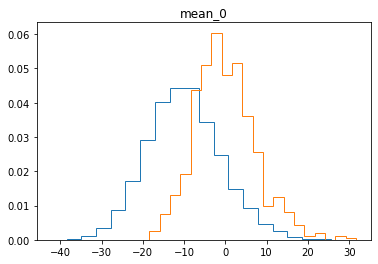

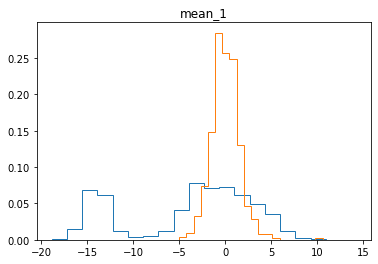

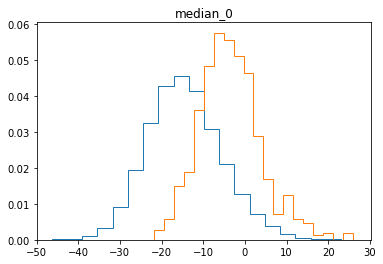

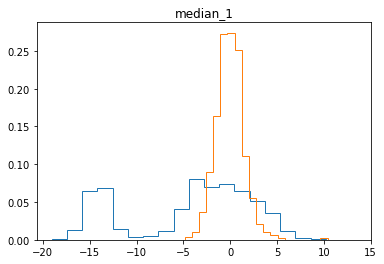

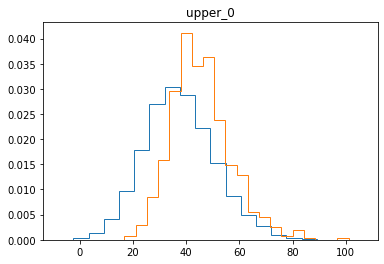

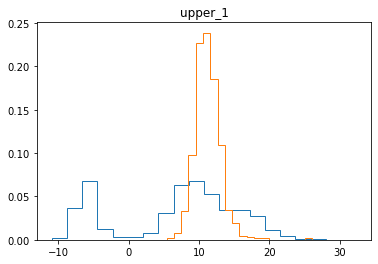

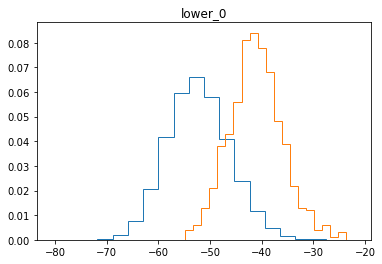

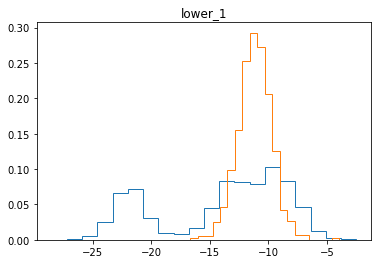

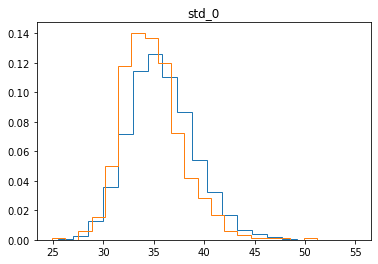

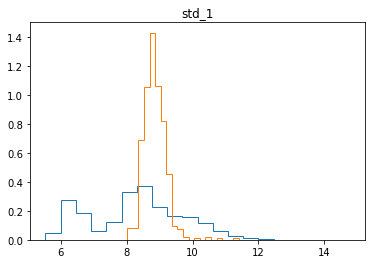

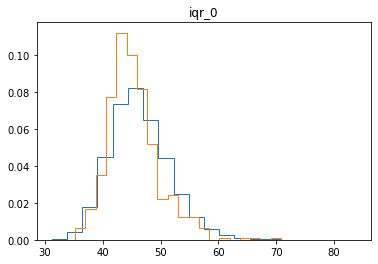

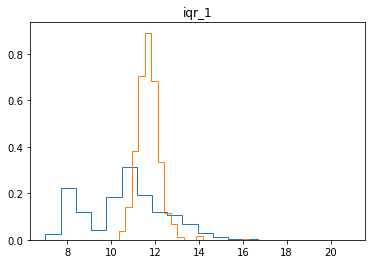

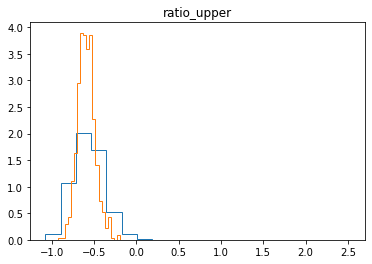

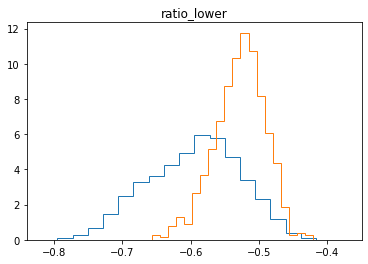

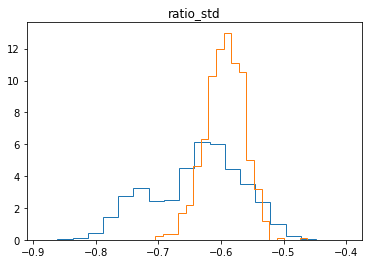

In [20]:
for c in features.columns:
    plt.figure()
    plt.hist(features.loc[features.index.str.contains("INT_116"),c],density=True,bins=20,histtype="step")
    plt.hist(features.loc[~features.index.str.contains("INT_116"),c],density=True,bins=20,histtype="step")
    plt.title(c)

# Raw export

In [21]:
features.to_hdf("%s/processed/features_unadjusted.hdf" % datadir, key="features")

# Time-cohort-machine find cohorts

## Sysmex cohort (PFC cohort)

In [22]:
sys_values = features.loc[~features.index.str.contains("INT_116")]

In [23]:
sys_phen = load_sys_phenotypes(data_dir)
sys_phen["time_col"] = pd.to_datetime(sys_phen["Date"],format="%d/%m/%Y")
sys_phen.sort_values("time_col",inplace=True)

602 candidates summary files
Initially 1068 rows, 643 unique IDs
Finally 642 rows, 642 unique IDs


In [24]:
sys_info = pd.merge(sys_values,sys_phen.set_index("ID")[["time_col"]],left_index=True,right_index=True).sort_values("time_col")

In [25]:
sys_info.head()

mean_0    mean_1  median_0  median_1    upper_0    upper_1  \
ID                                                                     
C0WX14 -5.497325 -0.430304 -8.801307 -0.248671  35.046187   9.741645   
C0WX4Z -0.958927 -0.669033 -4.762812 -1.043813  43.274748  11.005409   
C0WX6V -1.497133 -0.053734 -5.362014 -0.283413  45.070401  10.951034   
C0WX7T  2.848043  1.563287 -0.643392  1.333558  47.936865  12.702554   
C0WX8R  3.375183 -1.904844 -1.581603 -1.991711  51.023822   8.305408   

          lower_0    lower_1      std_0     std_1      iqr_0      iqr_1  \
ID                                                                        
C0WX14 -41.751377 -10.755764  32.389198  8.181019  40.438665  10.729390   
C0WX4Z -39.075309 -11.979563  32.933163  8.943662  41.664483  11.821426   
C0WX6V -42.820684 -11.166386  36.064001  8.768345  46.166257  11.063547   
C0WX7T -37.429296  -9.509349  34.645643  8.744881  45.496074  11.373403   
C0WX8R -37.515335 -12.753138  36.644559  8.377102  47.377530  11.005351   

        ratio_upper  ratio_lower  ratio_std   time_col  
ID                                                      
C0WX14    -0.548132    -0.496374  -0.597593 2016-01-12  
C0WX4Z    -0.565627    -0.496604  -0.566118 2016-01-12  
C0WX6V    -0.606062    -0.536805  -0.614156 2016-01-12  
C0WX7T    -0.612695    -0.530536  -0.597895 2016-01-12  
C0WX8R    -0.711687    -0.523632  -0.640916 2016-01-12

In [26]:
X = sys_info[features.columns].values
X -= np.mean(X,axis=0)
X /= np.std(X,axis=0)

In [27]:
algo_c = rp.KernelCPD(kernel="rbf", min_size=80).fit(
    X
)

4 BKPS


<Figure size 720x288 with 0 Axes>

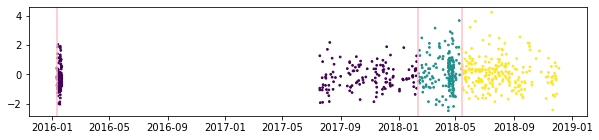

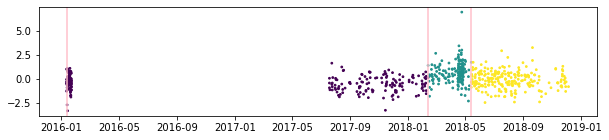

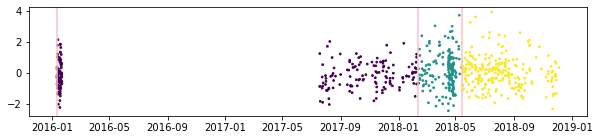

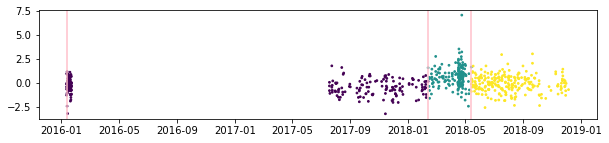

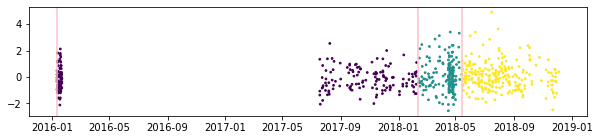

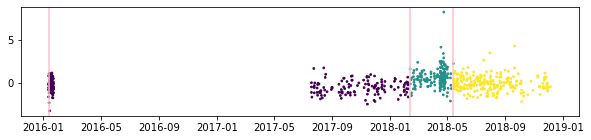

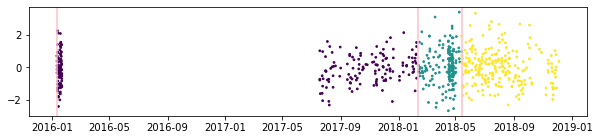

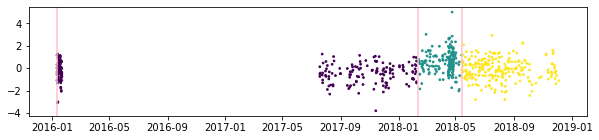

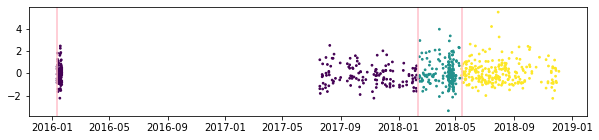

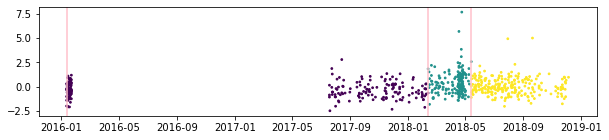

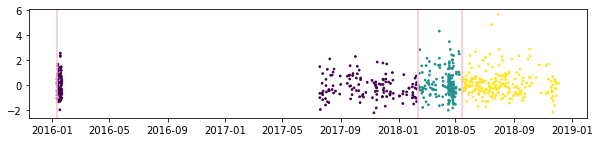

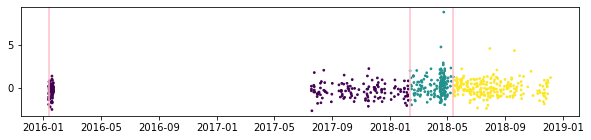

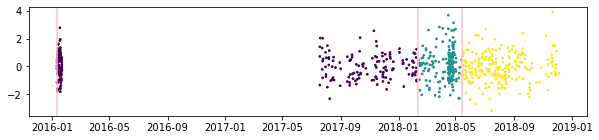

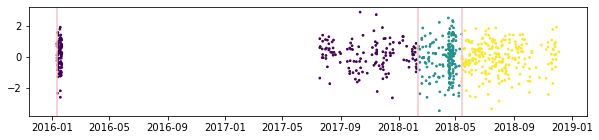

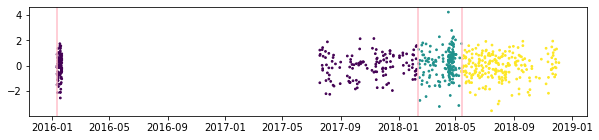

In [28]:
bkps = algo_c.predict(pen=2)
bkps = [0] + bkps
print("%d BKPS" % len(bkps))

sys_info["cohort"] = 0
sys_info["rank"] = np.arange(sys_info.shape[0])
for b in bkps[1:]:
    sys_info.loc[sys_info["rank"] >= b,"cohort"] += 1
    
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.figure(figsize=(10,2))
    plt.scatter(sys_info["time_col"],X[:,i],s=3,c=sys_info.cohort)
    for b in bkps[:-1]:
        plt.axvline(sys_info["time_col"].iloc[b],c="pink")

## Interval cohort

In [29]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max
Removing samples with less than 10 measurements per day
(30725, 782)


In [30]:
int_values = features.loc[features.index.str.contains("INT_116")]

13 BKPS
19 BKPS


<Figure size 720x288 with 0 Axes>

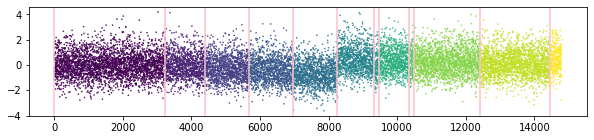

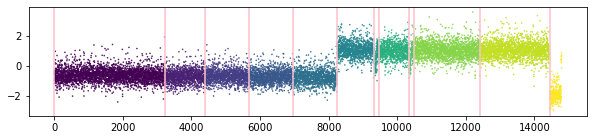

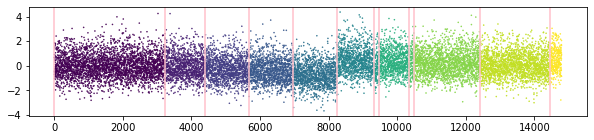

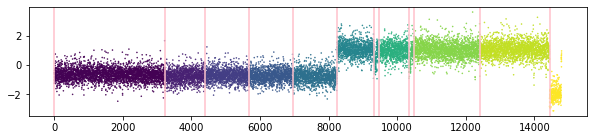

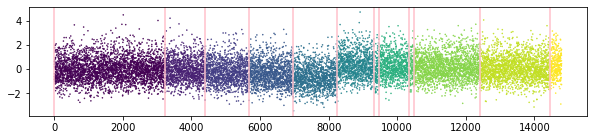

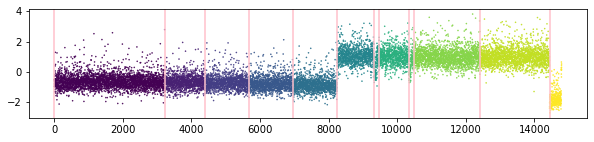

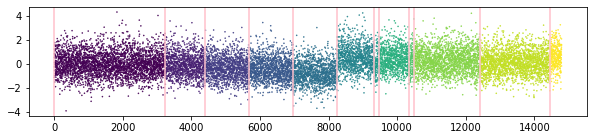

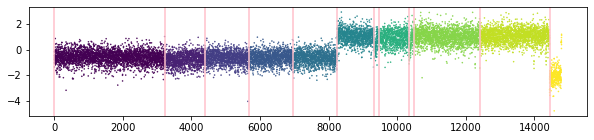

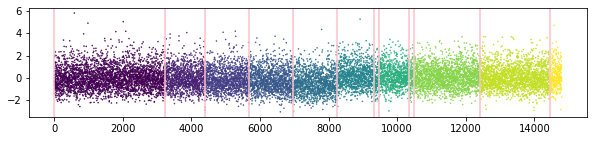

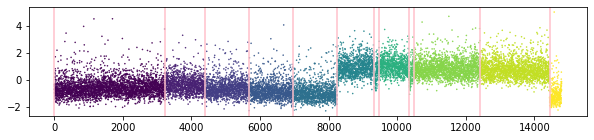

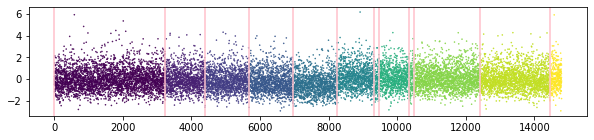

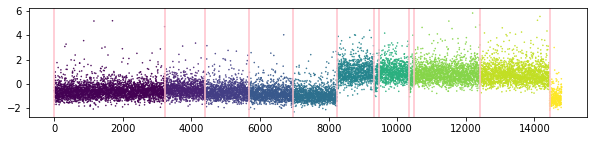

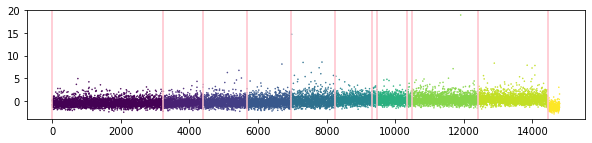

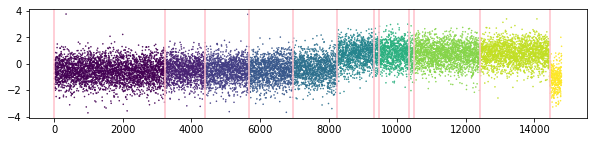

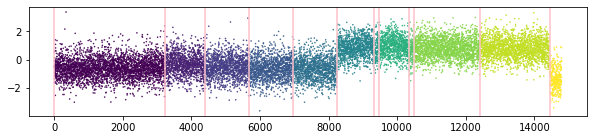

<Figure size 720x288 with 0 Axes>

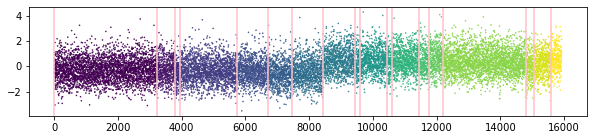

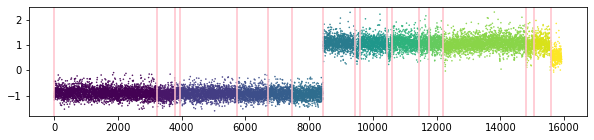

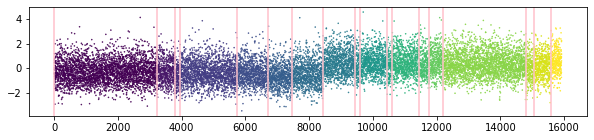

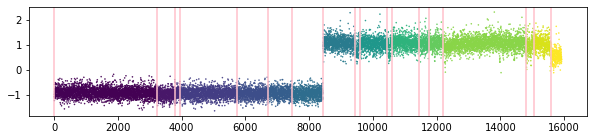

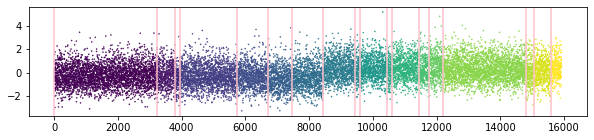

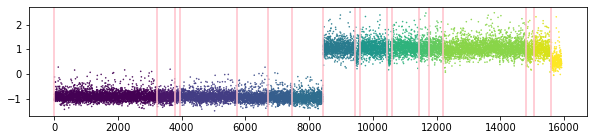

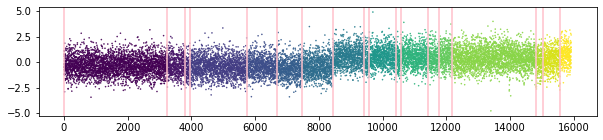

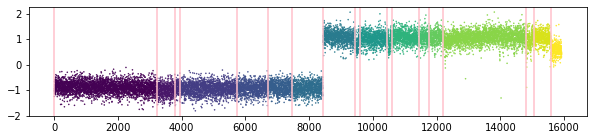

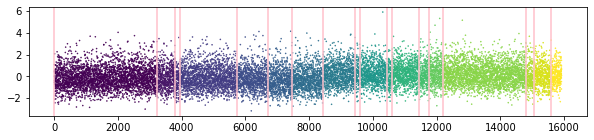

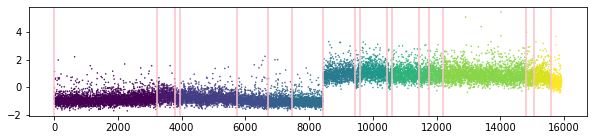

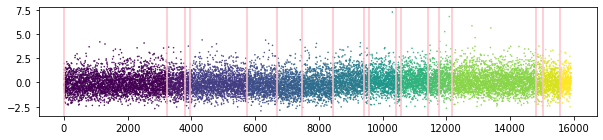

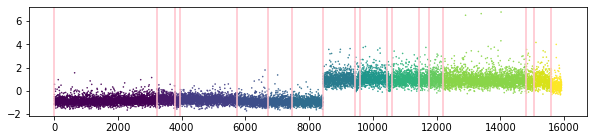

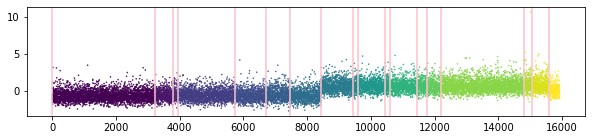

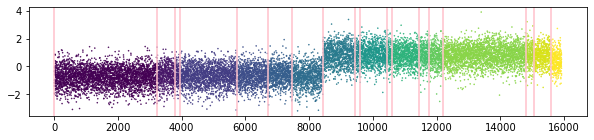

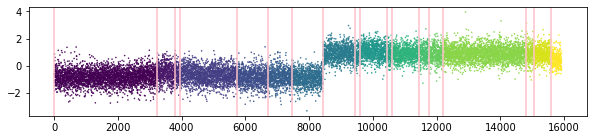

In [32]:
cohort_offset = sys_info.cohort.max() + 1
machines = int_phen["Instrument"].unique().tolist()
int_infos = []
for instrument in machines:
    int_info = pd.merge(int_values, int_phen.loc[int_phen.Instrument == instrument,
                                                      ["SampleNo","DateTime","day","Instrument"]],
                        left_index=True,right_on="SampleNo",how="inner")
    int_info["DateTime"] = pd.to_datetime(int_info["DateTime"])
    
    int_info.sort_values("DateTime",inplace=True)
    X = int_info[features.columns].values
    X -= np.mean(X,axis=0)
    X /= np.std(X,axis=0)
    
    algo_c = rp.KernelCPD(kernel="rbf", min_size=150).fit(
        X
    )
    
    bkps = algo_c.predict(pen=2.)
    bkps = [0] + bkps
    print("%d BKPS" % len(bkps))

    int_info["cohort"] = cohort_offset
    int_info["rank"] = np.arange(int_info.shape[0])
    for b in bkps[1:]:
        int_info.loc[int_info["rank"] >= b,"cohort"] += 1

    plt.figure(figsize=(10,4))
    for i in range(X.shape[1]):
        plt.figure(figsize=(10,2))
        plt.scatter(int_info["rank"],X[:,i],s=.3,c=int_info.cohort)
        for b in bkps[:-1]:
            plt.axvline(int_info["rank"].iloc[b],c="pink")
    int_infos.append(int_info)
    cohort_offset = int_info.cohort.max() + 1
int_info = pd.concat(int_infos,axis=0)

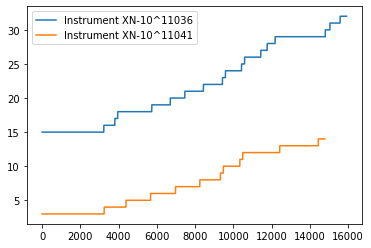

In [33]:
for machine, info in int_info.groupby("Instrument"):
    plt.plot(info["rank"],info.cohort,label="Instrument %s" % machine)
plt.legend()

In [173]:
def compute_intra_day_mean(df):
    # DF should contain samples of one machine x day
    for c in features.columns:
        df[c] = df[c].mean()
    df["n_samples"] = df.shape[0]
    return df


In [185]:
def find_outlier_days(df):
    # DF should be int_info groupby cohort
    overall_median = df[features.columns].median()
    median_difference = (df[features.columns] - overall_median).abs().median()
    
    df = df.groupby("day").apply(compute_intra_day_mean)
    for c in features.columns:
        df[c] = df[c] - overall_median[c]
    
    mean_diff_per_day = df.groupby("day")[features.columns].mean()
    n_exps_per_day = df.groupby("day")[features.columns].count()
    return np.sqrt(n_exps_per_day)*mean_diff_per_day[features.columns].abs()/median_difference[features.columns]
        #df["z_%s" % c] = np.sqrt(n_exps_per_day)*mean_diff_per_day[["day_mean_diff_%s" % c for c in features.columns]] / median_difference[c]


In [187]:
int_info_z_cols = int_info.copy().groupby("cohort").apply(find_outlier_days)

In [194]:
high_z_days = int_info_z_cols.loc[int_info_z_cols.max(axis=1) >= 8].index.tolist()

In [195]:
int_info_z_cols

mean_0    mean_1  median_0  median_1   upper_0   upper_1  \
cohort day                                                                      
3      2013-03-01  1.407023  1.175966  1.631151  0.856582  0.971049  1.949581   
       2013-03-02  1.566162  2.605303  1.375824  2.382959  1.696251  2.599260   
       2013-03-05  0.424172  0.402309  0.563669  0.331954  0.252477  0.440515   
       2013-03-06  2.027538  0.134684  2.341242  0.026831  1.357541  0.264017   
       2013-03-07  1.169321  1.733667  0.875278  1.954403  1.269247  1.052511   
...                     ...       ...       ...       ...       ...       ...   
32     2015-02-21  0.220657  1.468122  0.061841  1.534175  0.027473  0.920888   
       2015-02-24  2.526127  0.583145  2.224204  0.625438  1.939647  0.958006   
       2015-02-27  1.084970  0.019299  1.018465  0.154919  2.258557  0.576210   
       2015-03-13  1.440054  1.651433  1.616389  1.958827  1.723684  1.732771   
       2015-03-14  1.820893  3.397450  2.037122  3.209058  2.130673  3.084739   

                    lower_0   lower_1     std_0     std_1     iqr_0     iqr_1  \
cohort day                                                                      
3      2013-03-01  1.910895  0.932473  0.933069  2.144731  1.093276  1.233658   
       2013-03-02  0.871991  1.879768  1.426169  2.358417  1.263266  2.547226   
       2013-03-05  2.174853  0.026398  1.179210  1.503725  0.953217  0.694836   
       2013-03-06  3.295776  0.156249  0.335177  0.157337  1.040157  0.336479   
       2013-03-07  0.498009  1.625236  1.353139  0.734775  1.169082  0.565935   
...                     ...       ...       ...       ...       ...       ...   
32     2015-02-21  0.028838  1.576685  0.477849  0.316282  0.271908  1.283517   
       2015-02-24  2.793947  0.389977  1.050263  1.300136  1.413620  0.171564   
       2015-02-27  0.305856  0.375079  3.546806  1.620316  3.418861  0.918498   
       2015-03-13  1.323740  1.344641  2.016138  0.610090  1.933951  1.710401   
       2015-03-14  2.294164  3.984411  1.640433  0.699743  1.436802  0.146635   

                   ratio_upper  ratio_lower  ratio_std  
cohort day                                              
3      2013-03-01     0.845202     1.275894   0.844295  
       2013-03-02     1.910983     0.293996   0.278559  
       2013-03-05     0.957789     1.253564   0.172064  
       2013-03-06     0.135990     0.783598   0.303194  
       2013-03-07     3.248495     0.117040   1.173083  
...                        ...          ...        ...  
32     2015-02-21     0.213525     0.218172   0.641592  
       2015-02-24     4.055717     2.889892   2.417363  
       2015-02-27     1.515568     2.384366   2.690299  
       2015-03-13     1.001572     0.482837   1.729584  
       2015-03-14     2.594046     0.531707   2.281792  

[979 rows x 15 columns]

In [200]:
print("Removing samples from %d extreme days" % len(high_z_days))

Removing samples from 20 extreme days


In [198]:
int_info = int_info.set_index(["cohort","day"])
int_info = int_info.loc[~int_info.index.isin(high_z_days)].reset_index()

In [199]:
int_info.shape

(30038, 20)

In [193]:
high_z_days.shape

(20, 15)

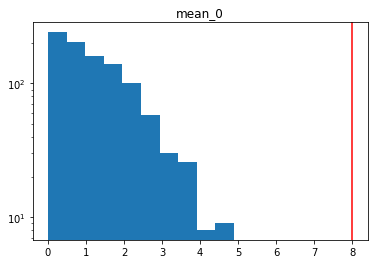

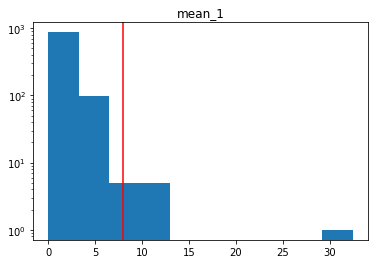

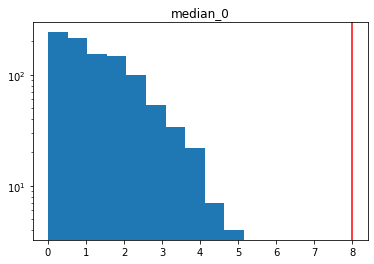

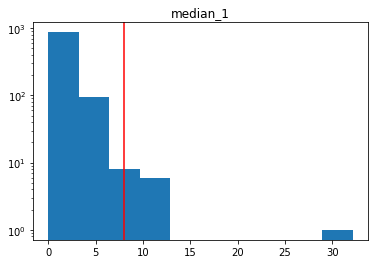

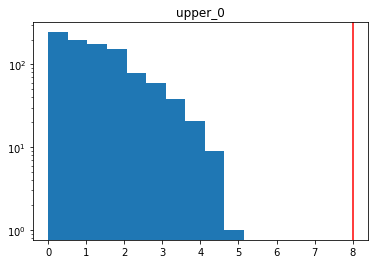

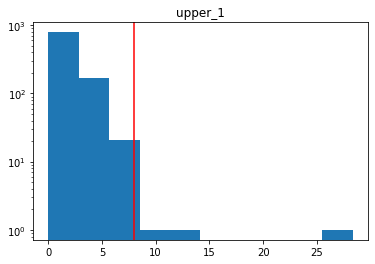

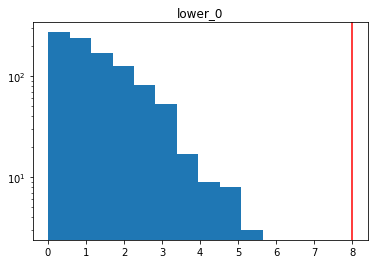

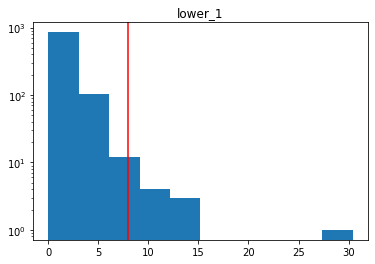

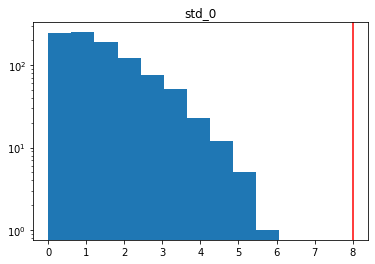

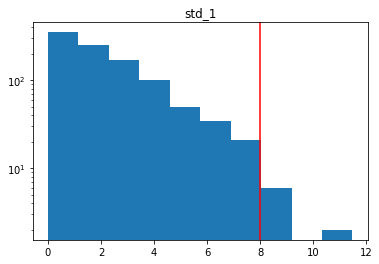

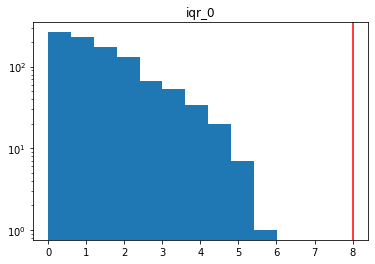

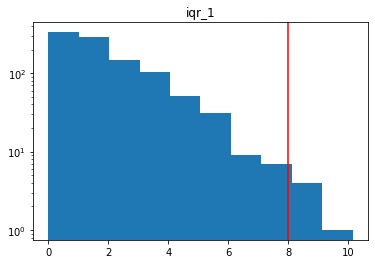

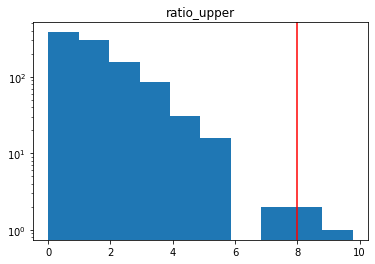

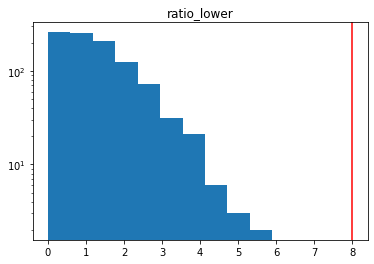

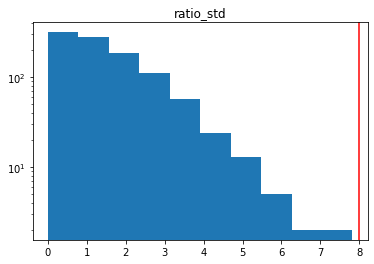

In [212]:
for z_col in int_info_z_cols.columns:
    plt.figure()
    plt.hist(int_info_z_cols[z_col])
    plt.title(z_col)
    plt.axvline(8,c="red")
    plt.yscale("log")

In [201]:
def append_day_rank(df):
    df = df.sort_values("DateTime")
    df["day_rank"] = np.arange(df.shape[0])
    return df

In [202]:
int_info = int_info.groupby("day").apply(append_day_rank)
del int_info["day"]
int_info = int_info.reset_index()
del int_info["level_1"]

In [203]:
int_info

day  cohort     mean_0    mean_1   median_0  median_1    upper_0  \
0     2013-03-01       3 -17.374145 -4.147360 -21.086967 -4.766642  29.382671   
1     2013-03-01       3  -5.450906 -2.235337  -9.065600 -2.792933  42.741376   
2     2013-03-01       3 -13.457352 -4.909176 -18.597571 -5.599350  32.468592   
3     2013-03-01       3  -3.298688 -2.624885  -7.025494 -3.198529  45.995321   
4     2013-03-01       3 -15.074745 -1.698876 -18.874834 -2.204896  26.509181   
...          ...     ...        ...       ...        ...       ...        ...   
30033 2015-03-14      32 -12.180750 -4.890266 -16.845573 -5.265215  33.613224   
30034 2015-03-14      32   9.467010 -3.479045   5.415494 -3.849043  63.515745   
30035 2015-03-14      32   9.646313 -4.313427   6.137005 -4.542968  60.770768   
30036 2015-03-14      32  -3.315966 -4.108869  -8.549937 -4.533852  46.154403   
30037 2015-03-14      32   0.584773 -4.904756  -3.638804 -5.043418  52.434426   

        upper_1    lower_0    lower_1  ...     std_1      iqr_0      iqr_1  \
0      7.463312 -59.127179 -14.625700  ...  8.604823  45.696093  11.177856   
1      8.778583 -49.815357 -12.946641  ...  8.825444  46.536348  11.501973   
2      6.507301 -54.263738 -15.590628  ...  8.914166  43.945107  10.984587   
3      9.013399 -45.978948 -13.700099  ...  8.970452  47.736169  11.150917   
4      9.052670 -52.334225 -11.915355  ...  8.576675  40.622443  11.118721   
...         ...        ...        ...  ...       ...        ...        ...   
30033  5.040620 -51.990669 -14.404636  ...  7.929482  42.186527  10.169388   
30034  6.488054 -39.676356 -13.459031  ...  8.028532  53.902815  10.413630   
30035  5.568804 -35.349276 -13.974515  ...  7.906652  51.565806  10.555013   
30036  5.952469 -45.523248 -13.700935  ...  7.875708  46.784222  10.214680   
30037  4.276378 -44.165142 -13.788536  ...  7.411985  51.080280   9.514074   

       ratio_upper  ratio_lower  ratio_std         SampleNo  \
0        -0.445957    -0.586407  -0.607676  INT_116_6580100   
1        -0.594949    -0.603500  -0.609760  INT_116_6580000   
2        -0.497535    -0.552635  -0.591654  INT_116_4555900   
3        -0.605127    -0.569292  -0.611745  INT_116_4555800   
4        -0.406650    -0.537278  -0.563241  INT_116_4556000   
...            ...          ...        ...              ...   
30033    -0.576626    -0.584946  -0.634061  INT_116_7187400   
30034    -0.814034    -0.671375  -0.701916  INT_116_3437600   
30035    -0.810177    -0.643322  -0.690815  INT_116_3437700   
30036    -0.684284    -0.605657  -0.659579  INT_116_1077600   
30037    -0.790094    -0.665972  -0.708379  INT_116_3433300   

                 DateTime   rank  day_rank  
0     2013-03-01 10:19:44      0         0  
1     2013-03-01 10:21:00      1         1  
2     2013-03-01 10:23:33      2         2  
3     2013-03-01 10:24:49      3         3  
4     2013-03-01 10:26:06      4         4  
...                   ...    ...       ...  
30033 2015-03-14 10:50:32  15916         5  
30034 2015-03-14 10:56:54  15917         6  
30035 2015-03-14 11:01:41  15918         7  
30036 2015-03-14 11:02:58  15919         8  
30037 2015-03-14 11:06:48  15920         9  

[30038 rows x 21 columns]

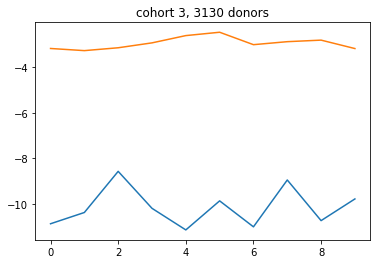

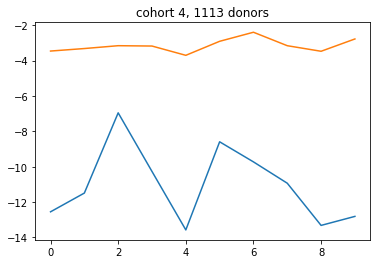

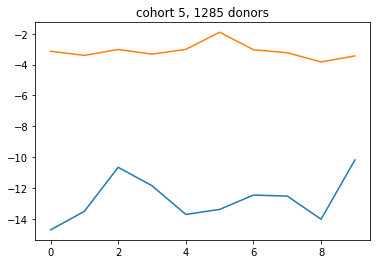

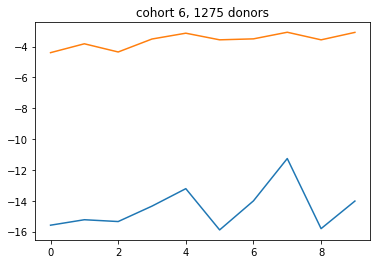

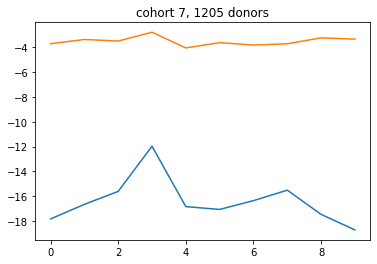

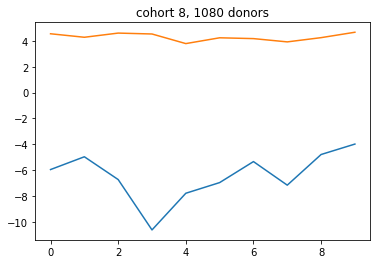

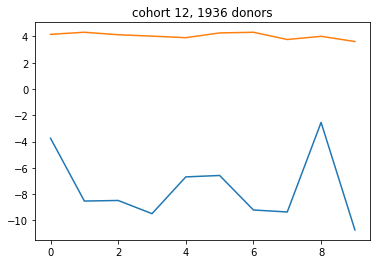

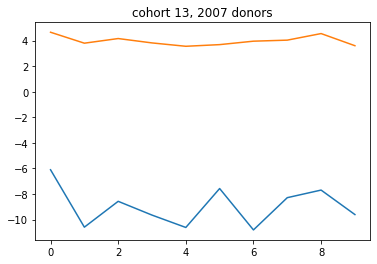

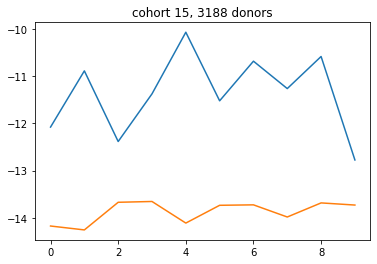

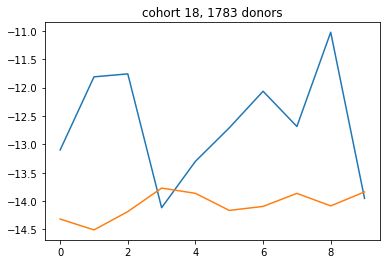

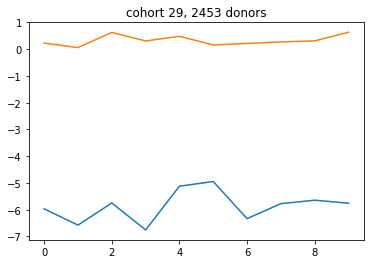

In [204]:
for cohort, df in int_info.groupby("cohort"):
    cohort_info = df.groupby("day_rank").agg({"mean_0":["mean","std"],"mean_1":["mean","std"],"SampleNo":"nunique"}).iloc[:10]
    if df.shape[0] < 1000: continue
    plt.figure()
    plt.title("cohort %d, %d donors" % (cohort, df.shape[0]))
    plt.plot(cohort_info[("mean_0","mean")])
    plt.plot(cohort_info[("mean_1","mean")])

In [205]:
cohort_info

mean_0               mean_1           SampleNo
              mean        std      mean       std  nunique
day_rank                                                  
0        -3.401534   9.318921 -3.678531  1.219691       17
1        -4.510204   9.936432 -3.353964  1.718754       17
2        -1.102741   6.751964 -4.034272  1.550993       14
3        -5.652966  10.121884 -2.383909  3.190217       12
4        -5.409142   8.812853 -3.336816  1.740574       16
5        -1.233926   6.422477 -2.949638  2.101548       16
6        -4.502930   9.594199 -3.034222  1.685649       10
7        -1.239345   7.342486 -3.140316  1.156624       13
8        -5.846419   9.867964 -3.299860  1.330576       18
9        -3.956444   7.881445 -3.756741  1.072686       11

## Age & sex

In [207]:
sys_agesex, int_agesex = get_ages_sex()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max
Removing samples with less than 10 measurements per day
(30725, 782)


## Gather

In [208]:
sys_all = pd.merge(sys_agesex,sys_info,left_index=True,right_index=True,how="inner").sort_values("time_col")
sys_all.head()

SEX   AGE    mean_0    mean_1  median_0  median_1    upper_0  \
C0WX14    2  67.0 -5.497325 -0.430304 -8.801307 -0.248671  35.046187   
C0WX4Z    2  63.0 -0.958927 -0.669033 -4.762812 -1.043813  43.274748   
C0WX6V    2  64.0 -1.497133 -0.053734 -5.362014 -0.283413  45.070401   
C0WX7T    2  70.0  2.848043  1.563287 -0.643392  1.333558  47.936865   
C0WX8R    2  71.0  3.375183 -1.904844 -1.581603 -1.991711  51.023822   

          upper_1    lower_0    lower_1      std_0     std_1      iqr_0  \
C0WX14   9.741645 -41.751377 -10.755764  32.389198  8.181019  40.438665   
C0WX4Z  11.005409 -39.075309 -11.979563  32.933163  8.943662  41.664483   
C0WX6V  10.951034 -42.820684 -11.166386  36.064001  8.768345  46.166257   
C0WX7T  12.702554 -37.429296  -9.509349  34.645643  8.744881  45.496074   
C0WX8R   8.305408 -37.515335 -12.753138  36.644559  8.377102  47.377530   

            iqr_1  ratio_upper  ratio_lower  ratio_std   time_col  cohort  \
C0WX14  10.729390    -0.548132    -0.496374  -0.597593 2016-01-12       0   
C0WX4Z  11.821426    -0.565627    -0.496604  -0.566118 2016-01-12       0   
C0WX6V  11.063547    -0.606062    -0.536805  -0.614156 2016-01-12       0   
C0WX7T  11.373403    -0.612695    -0.530536  -0.597895 2016-01-12       0   
C0WX8R  11.005351    -0.711687    -0.523632  -0.640916 2016-01-12       0   

        rank  
C0WX14     0  
C0WX4Z     1  
C0WX6V     2  
C0WX7T     3  
C0WX8R     4

In [209]:
int_all = pd.merge(int_agesex,int_info,left_index=True,right_on="SampleNo",how="inner").set_index("SampleNo").sort_values("DateTime")
int_all.head()

SEX   AGE        day  cohort     mean_0    mean_1   median_0  \
SampleNo                                                                        
INT_116_6580100    1  58.8 2013-03-01       3 -17.374145 -4.147360 -21.086967   
INT_116_6580000    2  22.6 2013-03-01       3  -5.450906 -2.235337  -9.065600   
INT_116_4555900    2  59.4 2013-03-01       3 -13.457352 -4.909176 -18.597571   
INT_116_4555800    2  21.3 2013-03-01       3  -3.298688 -2.624885  -7.025494   
INT_116_4556000    1  49.3 2013-03-01       3 -15.074745 -1.698876 -18.874834   

                 median_1    upper_0   upper_1  ...     std_1      iqr_0  \
SampleNo                                        ...                        
INT_116_6580100 -4.766642  29.382671  7.463312  ...  8.604823  45.696093   
INT_116_6580000 -2.792933  42.741376  8.778583  ...  8.825444  46.536348   
INT_116_4555900 -5.599350  32.468592  6.507301  ...  8.914166  43.945107   
INT_116_4555800 -3.198529  45.995321  9.013399  ...  8.970452  47.736169   
INT_116_4556000 -2.204896  26.509181  9.052670  ...  8.576675  40.622443   

                     iqr_1  ratio_upper  ratio_lower  ratio_std  \
SampleNo                                                          
INT_116_6580100  11.177856    -0.445957    -0.586407  -0.607676   
INT_116_6580000  11.501973    -0.594949    -0.603500  -0.609760   
INT_116_4555900  10.984587    -0.497535    -0.552635  -0.591654   
INT_116_4555800  11.150917    -0.605127    -0.569292  -0.611745   
INT_116_4556000  11.118721    -0.406650    -0.537278  -0.563241   

                           DateTime  rank  day_rank hour  
SampleNo                                                  
INT_116_6580100 2013-03-01 10:19:44     0         0   10  
INT_116_6580000 2013-03-01 10:21:00     1         1   10  
INT_116_4555900 2013-03-01 10:23:33     2         2   10  
INT_116_4555800 2013-03-01 10:24:49     3         3   10  
INT_116_4556000 2013-03-01 10:26:06     4         4   10  

[5 rows x 23 columns]

## Export without adjusting further

In [210]:
raw_features = pd.concat((sys_all[["SEX","AGE","cohort"]+list(features.columns)],
                          int_all[["SEX","AGE","cohort"]+list(features.columns)]),axis=0)

In [211]:
raw_features[features.columns].to_hdf("%s/processed/features.hdf" % datadir, key="features")
raw_features[["cohort"]].to_hdf("%s/processed/cohorts.hdf" % datadir, key="features")

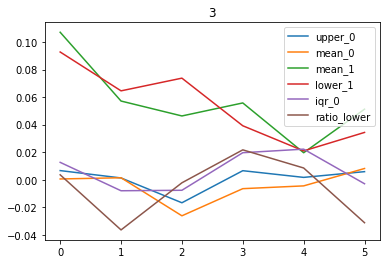

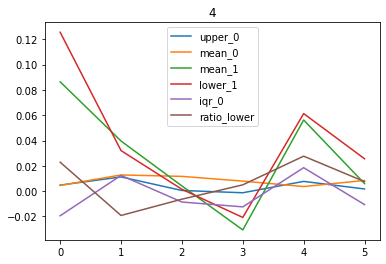

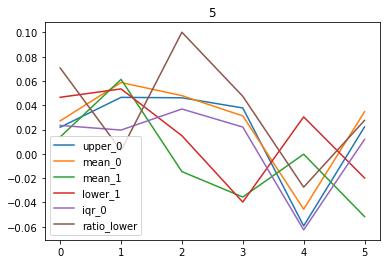

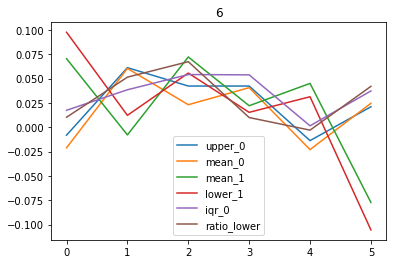

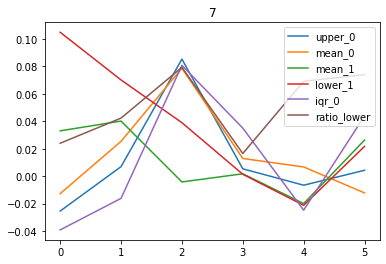

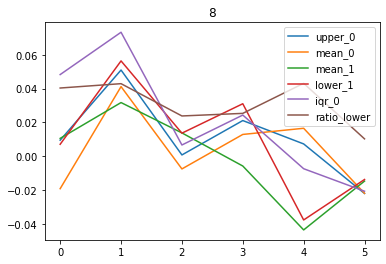

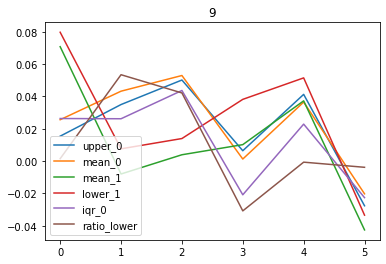

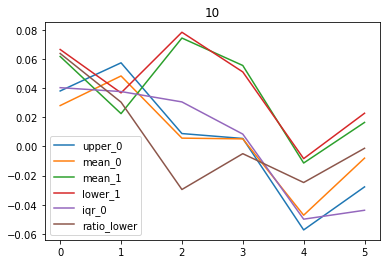

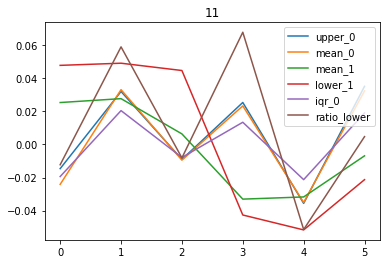

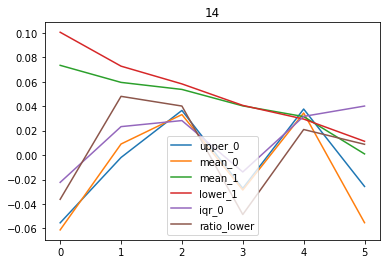

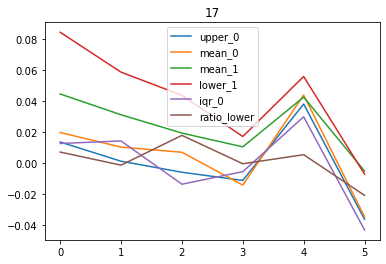

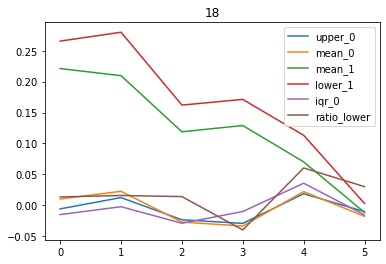

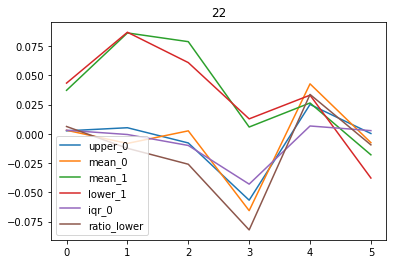

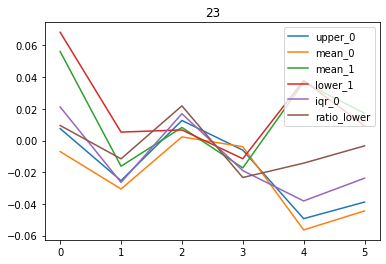

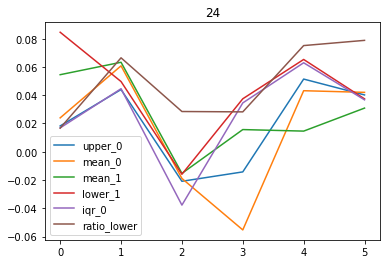

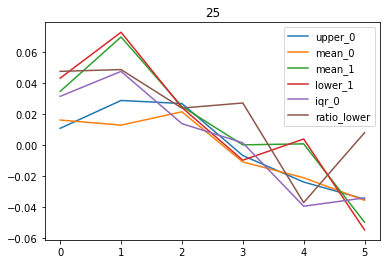

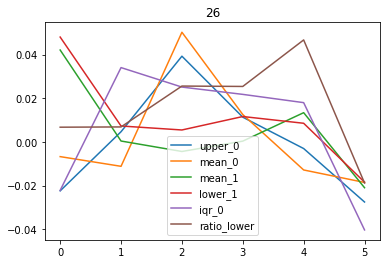

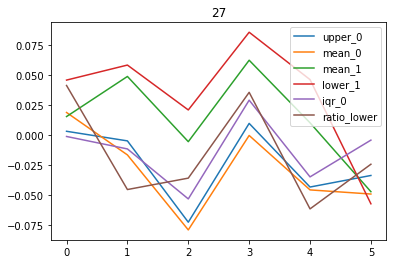

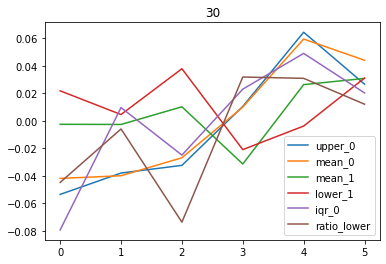

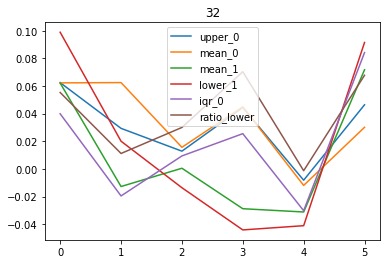

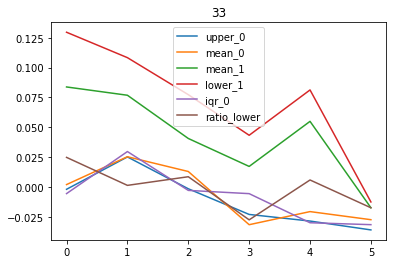

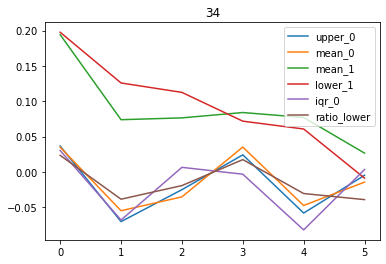

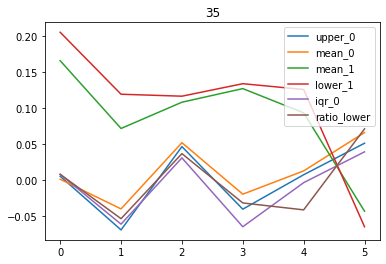

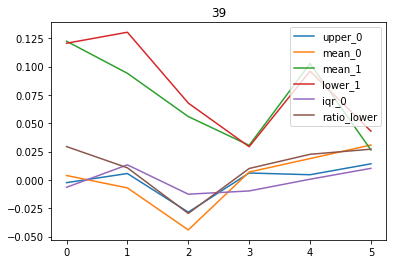

In [96]:
features_cols = ['upper_0', 'mean_0', 'mean_1', 'lower_1', 'iqr_0', 'ratio_lower']
for cohort, sub_int_info in int_info.groupby("cohort"):
    if sub_int_info.shape[0] < 500: continue
    plt.figure()
    plt.title(cohort)
    sub_int_info[features_cols] -= sub_int_info[features_cols].mean()
    sub_int_info[features_cols] /= sub_int_info[features_cols].std()
    for c in features_cols:
        deltas = [1,2,3,4,5,100]
        plt.plot(np.arange(len(deltas)),
                 [np.mean(sub_int_info[c].iloc[d:].values*sub_int_info[c].iloc[:-d].values) for d in deltas],
                label=c)
    plt.legend()

In [35]:
all_ = pd.concat((sys_all[["SEX","AGE","cohort"]+list(features.columns)],
                  int_all[["SEX","AGE","cohort"]+list(features.columns)]),axis=0)
X = pd.concat([all_[["SEX","AGE"]],pd.get_dummies(all_["cohort"],drop_first=True)],axis=1)
Y = all_[features.columns]
# IT IS DEGENERATE IF WE DON'T DROP THE FIRST LEVEL

In [36]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X,Y)
cohort_coefs = lm.coef_[:,2:]
print(cohort_coefs.shape)

(15, 34)


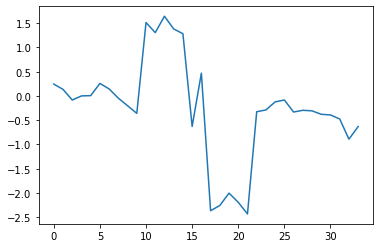

In [37]:
plt.plot(cohort_coefs[9])

In [38]:
for c in all_.cohort.unique().tolist():
    if c == 0: continue
    features.loc[features.index.isin(all_.loc[all_.cohort == c].index.tolist()),features.columns] -= cohort_coefs[:,c-1]

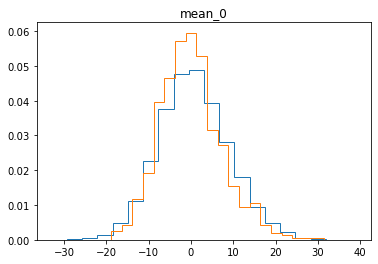

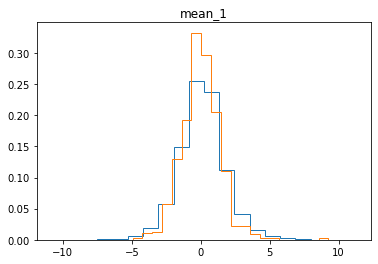

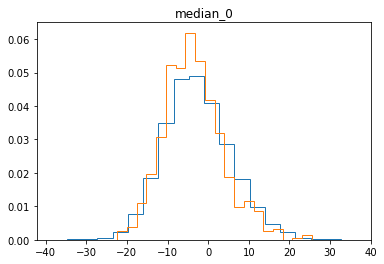

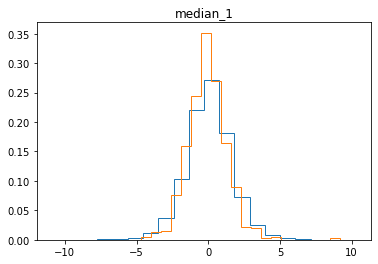

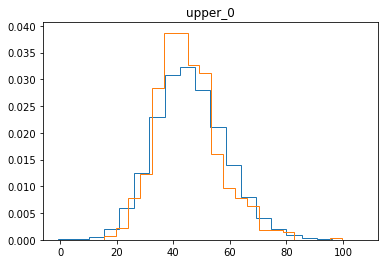

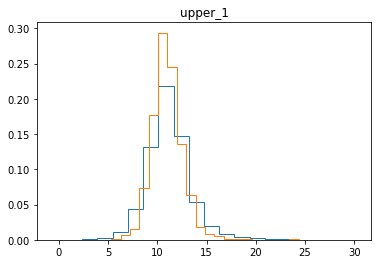

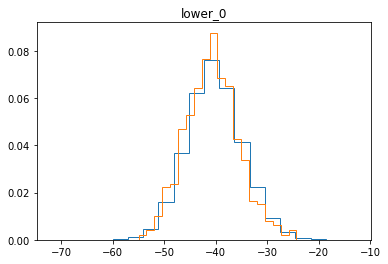

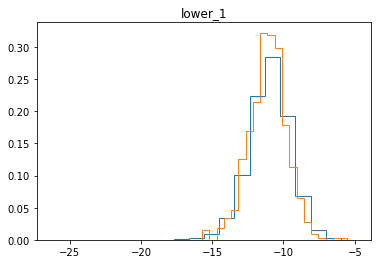

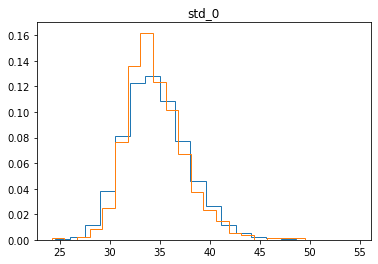

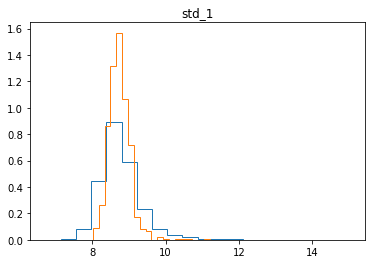

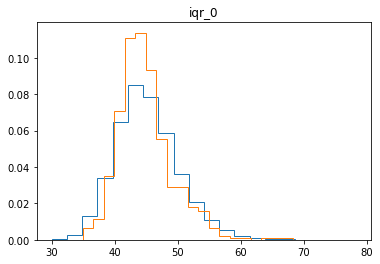

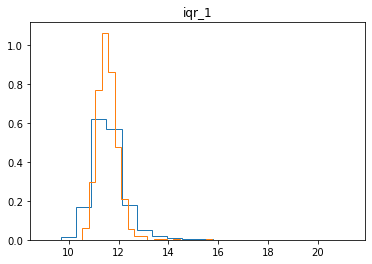

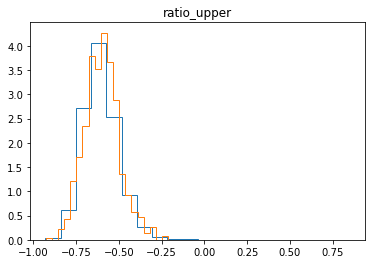

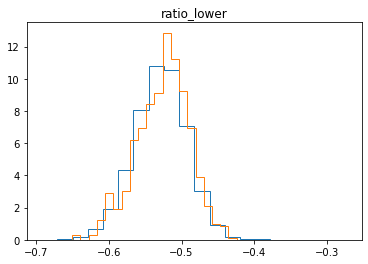

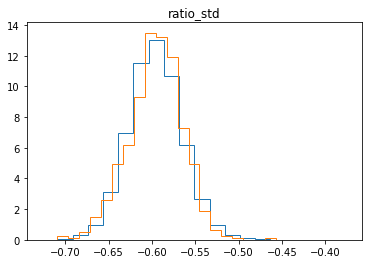

In [39]:
for c in features.columns:
    plt.figure()
    plt.hist(features.loc[features.index.str.contains("INT_116"),c],density=True,bins=20,histtype="step")
    plt.hist(features.loc[~features.index.str.contains("INT_116"),c],density=True,bins=20,histtype="step")
    plt.title(c)

## Clip outliers

In [40]:
for c in features.columns:
    median = np.median(features[c])
    std = np.std(features[c])
    m = median - 4*std
    M = median + 4*std
    outliers = (features[c] - median).abs() > 4*std
    print("%s : %d outliers" % (c, outliers.sum()))
    features[c] = np.clip(features[c],m,M)

mean_0 : 11 outliers
mean_1 : 75 outliers
median_0 : 14 outliers
median_1 : 64 outliers
upper_0 : 15 outliers
upper_1 : 191 outliers
lower_0 : 14 outliers
lower_1 : 46 outliers
std_0 : 35 outliers
std_1 : 212 outliers
iqr_0 : 58 outliers
iqr_1 : 228 outliers
ratio_upper : 81 outliers
ratio_lower : 18 outliers
ratio_std : 15 outliers


# Export

In [41]:
features.to_hdf("%s/processed/features.hdf" % datadir, key="features")